In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
file_path = 'Final Data.csv'
data = pd.read_csv(file_path)

label_encoders = {}
for col in ['District', 'Items']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

weather_columns = ['Root_Zone_Soil_Wetness',  'Forst Point 2 meter Temp',
                    'Wind speed 2 meters', 'Average Solar Radiation',
                   'Average Rainfall (mm)', 'Average Sunshine (Hours)', 'Average Cloud Coverage (Octs)',
                   'Average pet', 'Average Humidity (percent)', 'Average_Max_Temperature (Deg.Cel)',
                   'Average Min Temperature (Deg.Cel)']
scaler_weather = MinMaxScaler()
scaler_production = MinMaxScaler()

In [ ]:
data[weather_columns] = scaler_weather.fit_transform(data[weather_columns])


data['production'] = scaler_production.fit_transform(data['production'].values.reshape(-1, 1))


data_grouped = data.groupby(['District','Year','Items']).mean().reset_index()


def create_sequences(data, time_steps=6):
    sequences, labels = [], []
    for i in range(len(data) - time_steps):
        sequence = data.iloc[i:i + time_steps].values
        label = data.iloc[i + time_steps].values
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)


weather_sequences, weather_labels = create_sequences(data_grouped[weather_columns], time_steps=4)


X_train, X_test, y_train, y_test = train_test_split(weather_sequences, weather_labels, test_size=0.2, random_state=42)


model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.1),
    Dense(y_train.shape[1])
])



optimizer_weather = Adam(learning_rate=0.0006167)
model.compile(optimizer=optimizer_weather, loss='mse')



early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=80, batch_size=32, callbacks=[early_stopping])


model.save('bilstm_weat_model.h5')



weather_predictions_full = model.predict(weather_sequences)


data_grouped_predicted = data_grouped.copy()


In [ ]:
for i, col in enumerate(weather_columns):
    data_grouped_predicted[col].iloc[-len(weather_predictions_full):] = weather_predictions_full[:, i]


production_columns_predicted = ['production'] + weather_columns
production_sequences_predicted, production_labels_predicted = create_sequences(data_grouped_predicted[production_columns_predicted], time_steps=4)


X_train_prod_pred, X_test_prod_pred, y_train_prod_pred, y_test_prod_pred = train_test_split(production_sequences_predicted, production_labels_predicted, test_size=0.2, random_state=42)

model_prod_pred = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_prod_pred.shape[1], X_train_prod_pred.shape[2])),
    Dropout(0.1),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.1),
    Dense(y_train_prod_pred.shape[1])
])


optimizer_prod_pred = Adam(learning_rate=0.006167)


model_prod_pred.compile(optimizer=optimizer_prod_pred, loss='mse')
early_stopping_prod_pred = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history_prod_pred = model_prod_pred.fit(X_train_prod_pred, y_train_prod_pred, validation_data=(X_test_prod_pred, y_test_prod_pred), epochs=100, batch_size=32, callbacks=[early_stopping_prod_pred])


model_json = model_prod_pred.to_json()
with open("bilstm_mel.json", "w") as json_file:
    json_file.write(model_json)
model_prod_pred.save_weights("bilstm_weights.weights.h5")

In [ ]:
production_predictions_pred = model_prod_pred.predict(X_test_prod_pred)


production_predictions_pred_rescaled = scaler_production.inverse_transform(production_predictions_pred)


production_mse = mean_squared_error(y_test_prod_pred, production_predictions_pred)
production_rmse = np.sqrt(production_mse)
production_mae = mean_absolute_error(y_test_prod_pred, production_predictions_pred)
production_r2 = r2_score(y_test_prod_pred, production_predictions_pred)
production_mape = mean_absolute_percentage_error(y_test_prod_pred, production_predictions_pred)

threshold = 0.1
production_accuracy = np.mean(np.abs((y_test_prod_pred - production_predictions_pred) / y_test_prod_pred) < threshold) * 100



In [ ]:
print(f"Production Prediction - MSE: {production_mse}, RMSE: {production_rmse}, MAE: {production_mae}, R²: {production_r2}, MAPE: {production_mape}")
print(f"Production Prediction Custom Accuracy (within 10% threshold): {production_accuracy}%")


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss - Weather Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


plt.plot(history_prod_pred.history['loss'])
plt.plot(history_prod_pred.history['val_loss'])
plt.title('Model loss - Production Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


c:\Users\shefa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - loss: 0.0966 - val_loss: 0.0132
Epoch 2/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0156 - val_loss: 0.0067
Epoch 3/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0107 - val_loss: 0.0050
Epoch 4/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0084 - val_loss: 0.0044
Epoch 5/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0075 - val_loss: 0.0038
Epoch 6/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0071 - val_loss: 0.0039
Epoch 7/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0066 - val_loss: 0.0036
Epoch 8/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0063 - val_loss: 0.0035
Epoch 9/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0058 - val_loss: 0.0036
Epoch 10/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0057 - val_loss: 0.0033
Epoch 11/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0057 - val_loss: 0.0032
Epoch 12/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.

111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


C:\Users\shefa\AppData\Local\Temp\ipykernel_10816\3289032955.py:78: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_grouped_predicted[col].iloc[-len(weather_predictions_full):] = weather_predictions_full[:, i]
C:\Users\shefa\AppData\Local

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 17s 52ms/step - loss: 0.0398 - val_loss: 0.0076
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0092 - val_loss: 0.0060
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0072 - val_loss: 0.0065
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0061 - val_loss: 0.0047
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0057 - val_loss: 0.0053
Epoch 9/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 10/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 11/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 12/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/ste

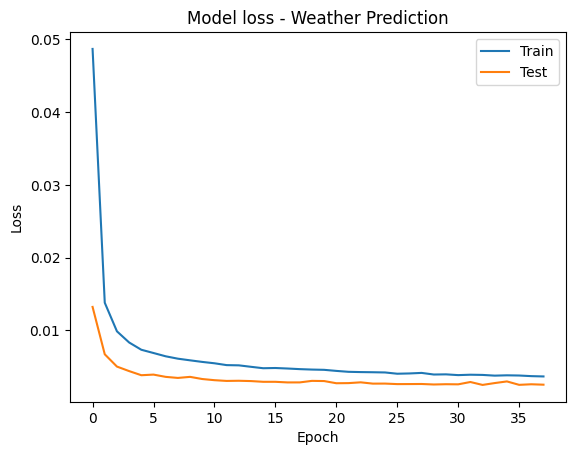

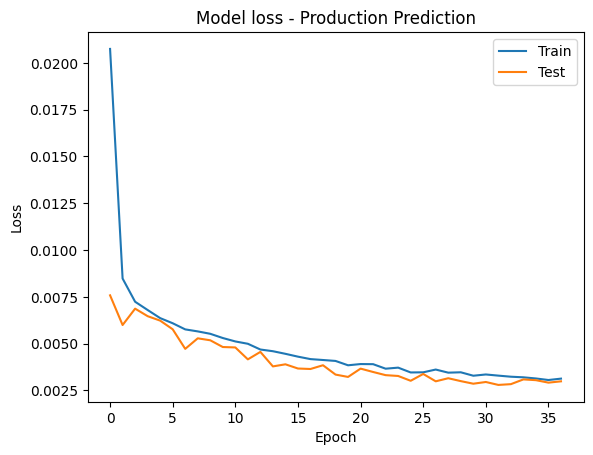

In [9]:
file_path = 'Final Data.csv'
data = pd.read_csv(file_path)

label_encoders = {}
for col in ['District', 'Items']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

weather_columns = ['Root_Zone_Soil_Wetness',  'Forst Point 2 meter Temp',
                    'Wind speed 2 meters', 'Average Solar Radiation',
                   'Average Rainfall (mm)', 'Average Sunshine (Hours)', 'Average Cloud Coverage (Octs)',
                   'Average pet', 'Average Humidity (percent)', 'Average_Max_Temperature (Deg.Cel)',
                   'Average Min Temperature (Deg.Cel)']
scaler_weather = MinMaxScaler()
scaler_production = MinMaxScaler()



data[weather_columns] = scaler_weather.fit_transform(data[weather_columns])


data['production'] = scaler_production.fit_transform(data['production'].values.reshape(-1, 1))


data_grouped = data.groupby(['District','Year','Items']).mean().reset_index()


def create_sequences(data, time_steps=6):
    sequences, labels = [], []
    for i in range(len(data) - time_steps):
        sequence = data.iloc[i:i + time_steps].values
        label = data.iloc[i + time_steps].values
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)


weather_sequences, weather_labels = create_sequences(data_grouped[weather_columns], time_steps=4)


X_train, X_test, y_train, y_test = train_test_split(weather_sequences, weather_labels, test_size=0.2, random_state=42)


model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.1),
    Dense(y_train.shape[1])
])



optimizer_weather = Adam(learning_rate=0.0006167)
model.compile(optimizer=optimizer_weather, loss='mse')



early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=80, batch_size=32, callbacks=[early_stopping])


model.save('bilstm_weat_model.h5')



weather_predictions_full = model.predict(weather_sequences)


data_grouped_predicted = data_grouped.copy()


for i, col in enumerate(weather_columns):
    data_grouped_predicted[col].iloc[-len(weather_predictions_full):] = weather_predictions_full[:, i]


production_columns_predicted = ['production'] + weather_columns
production_sequences_predicted, production_labels_predicted = create_sequences(data_grouped_predicted[production_columns_predicted], time_steps=4)


X_train_prod_pred, X_test_prod_pred, y_train_prod_pred, y_test_prod_pred = train_test_split(production_sequences_predicted, production_labels_predicted, test_size=0.2, random_state=42)

model_prod_pred = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_prod_pred.shape[1], X_train_prod_pred.shape[2])),
    Dropout(0.1),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.1),
    Dense(y_train_prod_pred.shape[1])
])


optimizer_prod_pred = Adam(learning_rate=0.006167)


model_prod_pred.compile(optimizer=optimizer_prod_pred, loss='mse')
early_stopping_prod_pred = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


history_prod_pred = model_prod_pred.fit(X_train_prod_pred, y_train_prod_pred, validation_data=(X_test_prod_pred, y_test_prod_pred), epochs=100, batch_size=32, callbacks=[early_stopping_prod_pred])


model_json = model_prod_pred.to_json()
with open("bilstm_mel.json", "w") as json_file:
    json_file.write(model_json)
model_prod_pred.save_weights("bilstm_weights.weights.h5")


production_predictions_pred = model_prod_pred.predict(X_test_prod_pred)


production_predictions_pred_rescaled = scaler_production.inverse_transform(production_predictions_pred)


production_mse = mean_squared_error(y_test_prod_pred, production_predictions_pred)
production_rmse = np.sqrt(production_mse)
production_mae = mean_absolute_error(y_test_prod_pred, production_predictions_pred)
production_r2 = r2_score(y_test_prod_pred, production_predictions_pred)
production_mape = mean_absolute_percentage_error(y_test_prod_pred, production_predictions_pred)

threshold = 0.1
production_accuracy = np.mean(np.abs((y_test_prod_pred - production_predictions_pred) / y_test_prod_pred) < threshold) * 100


print(f"Production Prediction - MSE: {production_mse}, RMSE: {production_rmse}, MAE: {production_mae}, R²: {production_r2}, MAPE: {production_mape}")
print(f"Production Prediction Custom Accuracy (within 10% threshold): {production_accuracy}%")


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss - Weather Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


plt.plot(history_prod_pred.history['loss'])
plt.plot(history_prod_pred.history['val_loss'])
plt.title('Model loss - Production Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


c:\Users\shefa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0995 - val_loss: 0.0122
Epoch 2/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0147 - val_loss: 0.0064
Epoch 3/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0102 - val_loss: 0.0051
Epoch 4/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0084 - val_loss: 0.0045
Epoch 5/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0076 - val_loss: 0.0040
Epoch 6/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0073 - val_loss: 0.0041
Epoch 7/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0069 - val_loss: 0.0036
Epoch 8/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0065 - val_loss: 0.0035
Epoch 9/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0063 - val_loss: 0.0034
Epoch 10/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0056 - val_loss: 0.0033
Epoch 11/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0057 - val_loss: 0.0033
Epoch 12/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
Weather Prediction - MSE: 60.281899740409955
Weather Prediction - RMSE: 7.764141919131177
Weather Prediction - MAE: 2.0251406036507653
Weather Prediction - MAPE: 2.0823732112826243%
Weather Prediction - R²: 0.8986566578403743


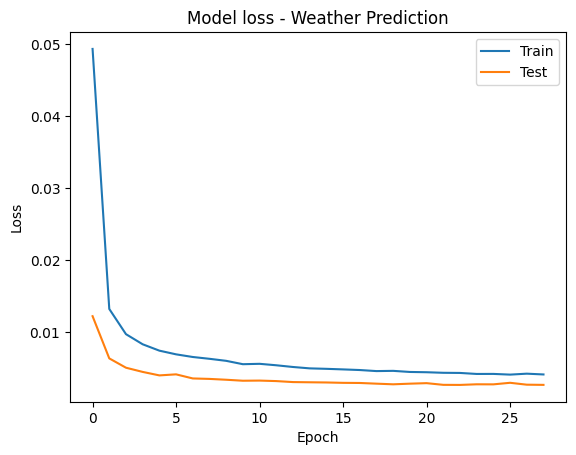

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
file_path = 'Final Data.csv'
data = pd.read_csv(file_path)

# Label encode categorical features 'District' and 'Items'
label_encoders = {}
for col in ['District', 'Items']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Define weather-related columns
weather_columns = ['Root_Zone_Soil_Wetness', 'Forst Point 2 meter Temp',
                   'Wind speed 2 meters', 'Average Solar Radiation',
                   'Average Rainfall (mm)', 'Average Sunshine (Hours)',
                   'Average Cloud Coverage (Octs)', 'Average pet',
                   'Average Humidity (percent)', 'Average_Max_Temperature (Deg.Cel)',
                   'Average Min Temperature (Deg.Cel)']

# Initialize MinMaxScaler for weather normalization
scaler_weather = MinMaxScaler()
data[weather_columns] = scaler_weather.fit_transform(data[weather_columns])

# Group data by district and year
data_grouped = data.groupby(['District', 'Year', 'Items']).mean().reset_index()

# Function to create sequences
def create_sequences(data, time_steps=4):
    sequences, labels = [], []
    for i in range(len(data) - time_steps):
        sequence = data.iloc[i:i + time_steps].values
        label = data.iloc[i + time_steps].values
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Prepare the weather data sequences
weather_sequences, weather_labels = create_sequences(data_grouped[weather_columns], time_steps=4)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(weather_sequences, weather_labels, test_size=0.2, random_state=42)

# Build BiLSTM model for weather prediction
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.1),
    Dense(y_train.shape[1])
])

# Compile the model with Adam optimizer
optimizer_weather = Adam(learning_rate=0.0006167)
model.compile(optimizer=optimizer_weather, loss='mse')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=80, batch_size=32, callbacks=[early_stopping])

# Save the trained model
model.save('bilstm_weather_model.h5')

# Predict weather values on test set
weather_predictions = model.predict(X_test)

# Convert predictions and actual values back to original scale
weather_predictions_rescaled = scaler_weather.inverse_transform(weather_predictions)
y_test_rescaled = scaler_weather.inverse_transform(y_test)

# Calculate error metrics
weather_mse = mean_squared_error(y_test_rescaled, weather_predictions_rescaled)
weather_rmse = np.sqrt(weather_mse)
weather_mae = mean_absolute_error(y_test_rescaled, weather_predictions_rescaled)

# Calculate Mean Absolute Percentage Error (MAPE)
weather_mape = np.mean(np.abs((y_test_rescaled - weather_predictions_rescaled) / y_test_rescaled)) * 100

# Calculate R² score
weather_r2 = r2_score(y_test_rescaled, weather_predictions_rescaled)

# Print results
print(f"Weather Prediction - MSE: {weather_mse}")
print(f"Weather Prediction - RMSE: {weather_rmse}")
print(f"Weather Prediction - MAE: {weather_mae}")
print(f"Weather Prediction - MAPE: {weather_mape}%")
print(f"Weather Prediction - R²: {weather_r2}")

# Plot loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss - Weather Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


Epoch 1/150


c:\Users\shefa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


177/177 ━━━━━━━━━━━━━━━━━━━━ 23s 41ms/step - loss: 6.2341 - val_loss: 2.2186
Epoch 2/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 1.7174 - val_loss: 0.6569
Epoch 3/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.5601 - val_loss: 0.2816
Epoch 4/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.2860 - val_loss: 0.1852
Epoch 5/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.2153 - val_loss: 0.1510
Epoch 6/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1819 - val_loss: 0.1357
Epoch 7/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.1707 - val_loss: 0.1310
Epoch 8/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.1607 - val_loss: 0.1219
Epoch 9/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.1570 - val_loss: 0.1135
Epoch 10/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.1466 - val_loss: 0.1107
Epoch 11/150
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.1483 - val_loss: 0.1085
Epoch 12/150
177/177 ━━━━━━━━━━━━━━━━━━━━

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step
✅ Optimized Weather Prediction Metrics:
MSE: 54.1584
RMSE: 7.3592
MAE: 2.1869
MAPE: 2.3180%
R² Score: 0.9031


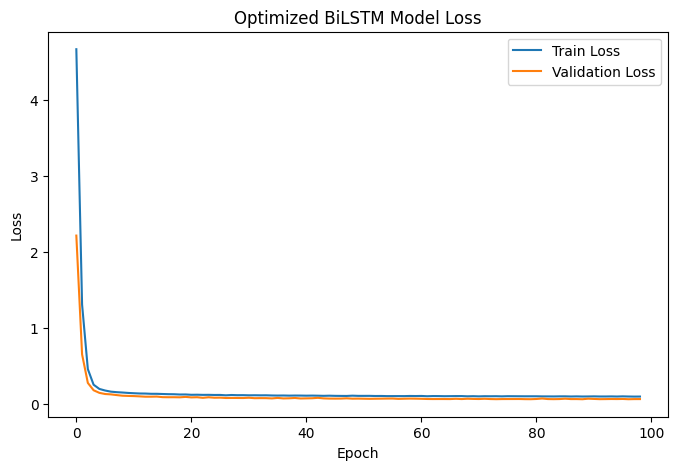

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the dataset
file_path = 'Final Data.csv'
data = pd.read_csv(file_path)

# Label encode categorical features
label_encoders = {}
for col in ['District', 'Items']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Define weather-related columns
weather_columns = [
    'Root_Zone_Soil_Wetness', 'Forst Point 2 meter Temp', 'Wind speed 2 meters', 
    'Average Solar Radiation', 'Average Rainfall (mm)', 'Average Sunshine (Hours)',
    'Average Cloud Coverage (Octs)', 'Average pet', 'Average Humidity (percent)',
    'Average_Max_Temperature (Deg.Cel)', 'Average Min Temperature (Deg.Cel)'
]

# Feature Engineering: Adding Lag Features (Previous Year’s Weather Data)
for col in weather_columns:
    data[col + '_Lag1'] = data[col].shift(1)

# Drop NaN values introduced by shifting
data.dropna(inplace=True)

# Initialize RobustScaler (Better than MinMaxScaler for outliers)
scaler_weather = RobustScaler()
data[weather_columns] = scaler_weather.fit_transform(data[weather_columns])

# Group data by district and year
data_grouped = data.groupby(['District', 'Year', 'Items']).mean().reset_index()

# Function to create sequences for BiLSTM
def create_sequences(data, time_steps=4):
    sequences, labels = [], []
    for i in range(len(data) - time_steps):
        sequence = data.iloc[i:i + time_steps].values
        label = data.iloc[i + time_steps].values
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Prepare the weather data sequences
weather_sequences, weather_labels = create_sequences(data_grouped[weather_columns], time_steps=4)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(weather_sequences, weather_labels, test_size=0.2, random_state=42)

# Build Optimized BiLSTM-GRU Hybrid Model
model = Sequential([
    Bidirectional(GRU(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))),  # L2 Regularization
    Dropout(0.3),
    Bidirectional(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01))),
    Dropout(0.3),
    Dense(y_train.shape[1])
])

# Compile the model with a lower learning rate for better optimization
optimizer_weather = Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer_weather, loss='mse')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with increased epochs and reduced batch size
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=16, callbacks=[early_stopping])

# Save the trained model
model.save('optimized_bilstm_weather_model.h5')

# Predict weather values on test set
weather_predictions = model.predict(X_test)

# Convert predictions and actual values back to original scale
weather_predictions_rescaled = scaler_weather.inverse_transform(weather_predictions)
y_test_rescaled = scaler_weather.inverse_transform(y_test)

# Calculate Error Metrics
weather_mse = mean_squared_error(y_test_rescaled, weather_predictions_rescaled)
weather_rmse = np.sqrt(weather_mse)
weather_mae = mean_absolute_error(y_test_rescaled, weather_predictions_rescaled)
weather_mape = np.mean(np.abs((y_test_rescaled - weather_predictions_rescaled) / y_test_rescaled)) * 100
weather_r2 = r2_score(y_test_rescaled, weather_predictions_rescaled)

# Print Results
print(f"✅ Optimized Weather Prediction Metrics:")
print(f"MSE: {weather_mse:.4f}")
print(f"RMSE: {weather_rmse:.4f}")
print(f"MAE: {weather_mae:.4f}")
print(f"MAPE: {weather_mape:.4f}%")
print(f"R² Score: {weather_r2:.4f}")

# Plot loss curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Optimized BiLSTM Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt


In [10]:
from sklearn.metrics import r2_score

# Weather Prediction Validation R²
weather_r2 = r2_score(y_test, model.predict(X_test))
print(f"Weather Prediction Validation R²: {weather_r2}")

# Production Prediction Validation R²
production_r2 = r2_score(y_test_prod_pred, model_prod_pred.predict(X_test_prod_pred))
print(f"Production Prediction Validation R²: {production_r2}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
Weather Prediction Validation R²: 0.904541743039259
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Production Prediction Validation R²: 0.9141188672919731


In [40]:
from tensorflow.keras.regularizers import l2

Dense(y_train_prod.shape[1], activation='relu', kernel_regularizer=l2(0.01))


<Dense name=dense_11, built=False>

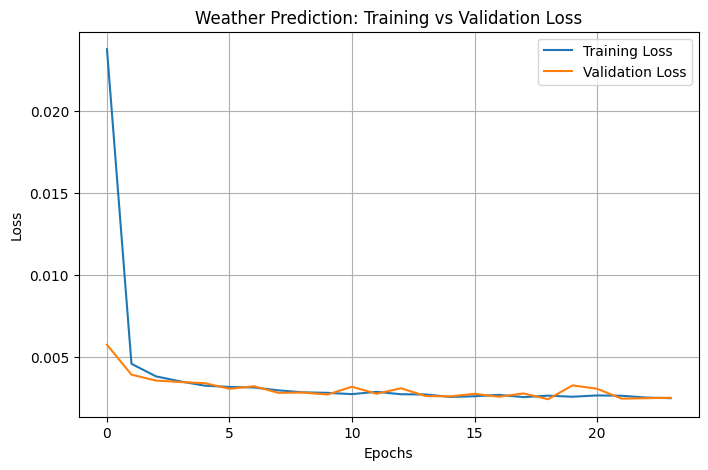

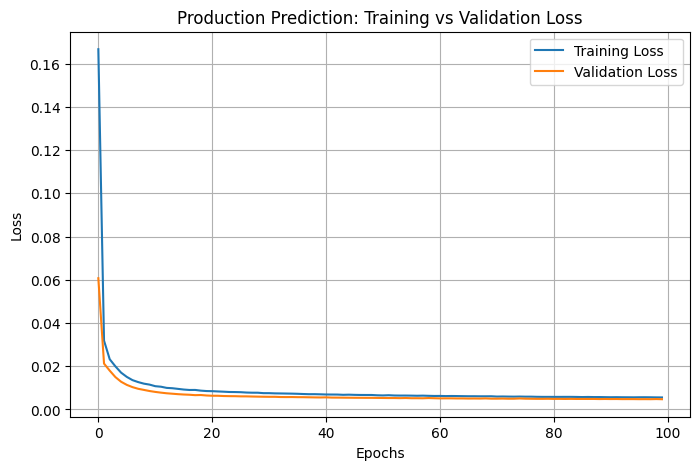

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


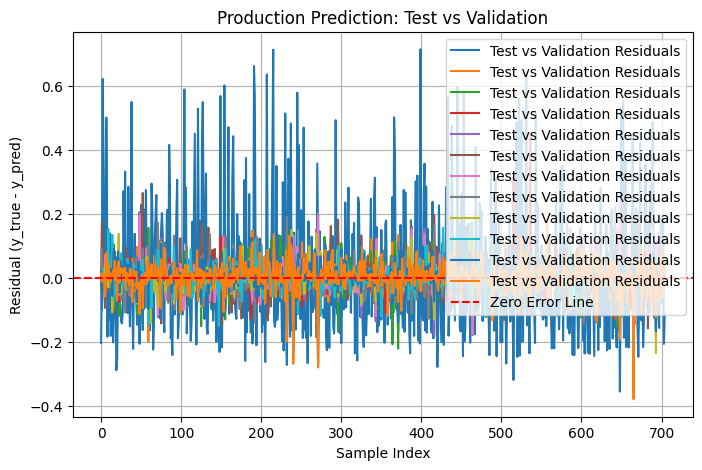

In [6]:
import matplotlib.pyplot as plt

# Plot Training vs Validation Loss for Weather Prediction
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Weather Prediction: Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training vs Validation Loss for Production Prediction
plt.figure(figsize=(8, 5))
plt.plot(history_prod_pred.history['loss'], label='Training Loss')
plt.plot(history_prod_pred.history['val_loss'], label='Validation Loss')
plt.title('Production Prediction: Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Test vs Validation (Residual Errors)
production_predictions_test = model_prod_pred.predict(X_test_prod_pred)
test_residuals = y_test_prod_pred - production_predictions_test

plt.figure(figsize=(8, 5))
plt.plot(test_residuals, label='Test vs Validation Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Error Line')
plt.title('Production Prediction: Test vs Validation')
plt.xlabel('Sample Index')
plt.ylabel('Residual (y_true - y_pred)')
plt.legend()
plt.grid(True)
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


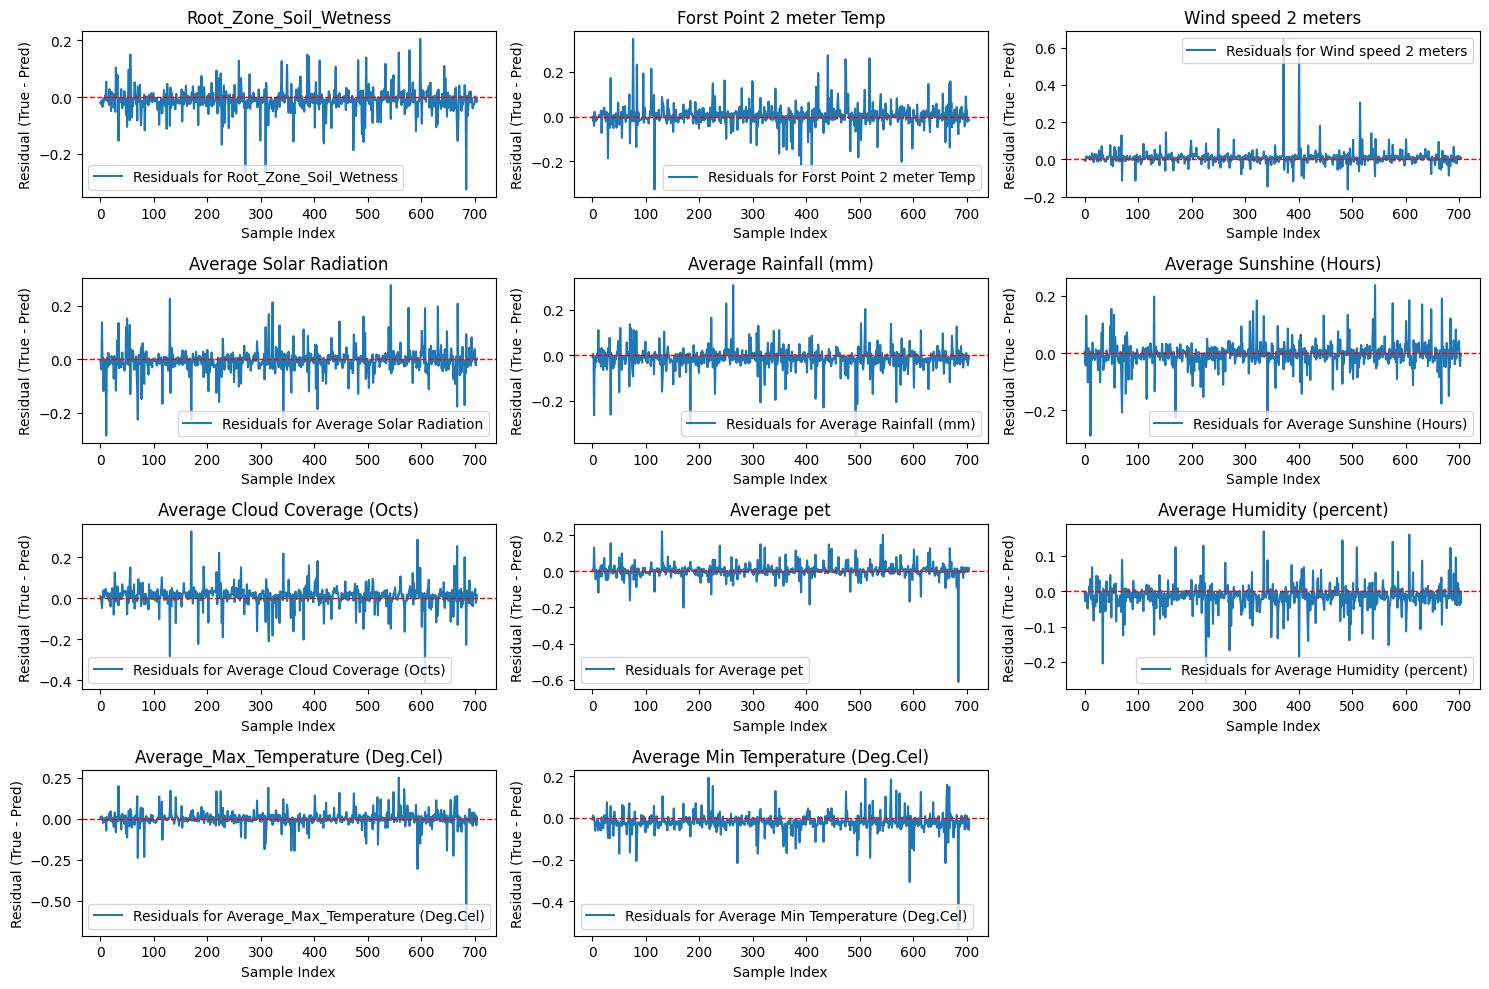

In [7]:
import matplotlib.pyplot as plt

# Generate predictions for weather features
weather_predictions = model.predict(X_test)

# Calculate residuals for each weather feature
residuals = y_test - weather_predictions

# Plot residuals for each weather feature
plt.figure(figsize=(15, 10))
for i, feature in enumerate(weather_columns):
    plt.subplot(4, 3, i + 1)  # Create subplots in a 4x3 grid
    plt.plot(residuals[:, i], label=f'Residuals for {feature}')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)  # Zero error line
    plt.title(feature)
    plt.xlabel('Sample Index')
    plt.ylabel('Residual (True - Pred)')
    plt.legend()
    plt.tight_layout()

plt.show()


In [11]:
from sklearn.metrics import r2_score


weather_predictions = model.predict(X_test)


feature_r2_scores = {}
for i, feature in enumerate(weather_columns):
    r2 = r2_score(y_test[:, i], weather_predictions[:, i])  # True vs Predicted for each feature
    feature_r2_scores[feature] = r2


for feature, r2 in feature_r2_scores.items():
    print(f"Feature: {feature}, R²: {r2:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Feature: Root_Zone_Soil_Wetness, R²: 0.9514
Feature: Forst Point 2 meter Temp, R²: 0.9183
Feature: Wind speed 2 meters, R²: 0.9012
Feature: Average Solar Radiation, R²: 0.9124
Feature: Average Rainfall (mm), R²: 0.8620
Feature: Average Sunshine (Hours), R²: 0.9086
Feature: Average Cloud Coverage (Octs), R²: 0.8512
Feature: Average pet, R²: 0.8643
Feature: Average Humidity (percent), R²: 0.9391
Feature: Average_Max_Temperature (Deg.Cel), R²: 0.9199
Feature: Average Min Temperature (Deg.Cel), R²: 0.9216


In [9]:
from sklearn.metrics import mean_squared_error


weather_predictions = model.predict(X_test)


feature_mse_scores = {}
for i, feature in enumerate(weather_columns):
    mse = mean_squared_error(y_test[:, i], weather_predictions[:, i])  # True vs Predicted for each feature
    feature_mse_scores[feature] = mse


for feature, mse in feature_mse_scores.items():
    print(f"Feature: {feature}, MSE: {mse:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Feature: Root_Zone_Soil_Wetness, MSE: 0.0022
Feature: Forst Point 2 meter Temp, MSE: 0.0028
Feature: Wind speed 2 meters, MSE: 0.0021
Feature: Average Solar Radiation, MSE: 0.0024
Feature: Average Rainfall (mm), MSE: 0.0028
Feature: Average Sunshine (Hours), MSE: 0.0021
Feature: Average Cloud Coverage (Octs), MSE: 0.0030
Feature: Average pet, MSE: 0.0019
Feature: Average Humidity (percent), MSE: 0.0016
Feature: Average_Max_Temperature (Deg.Cel), MSE: 0.0029
Feature: Average Min Temperature (Deg.Cel), MSE: 0.0026


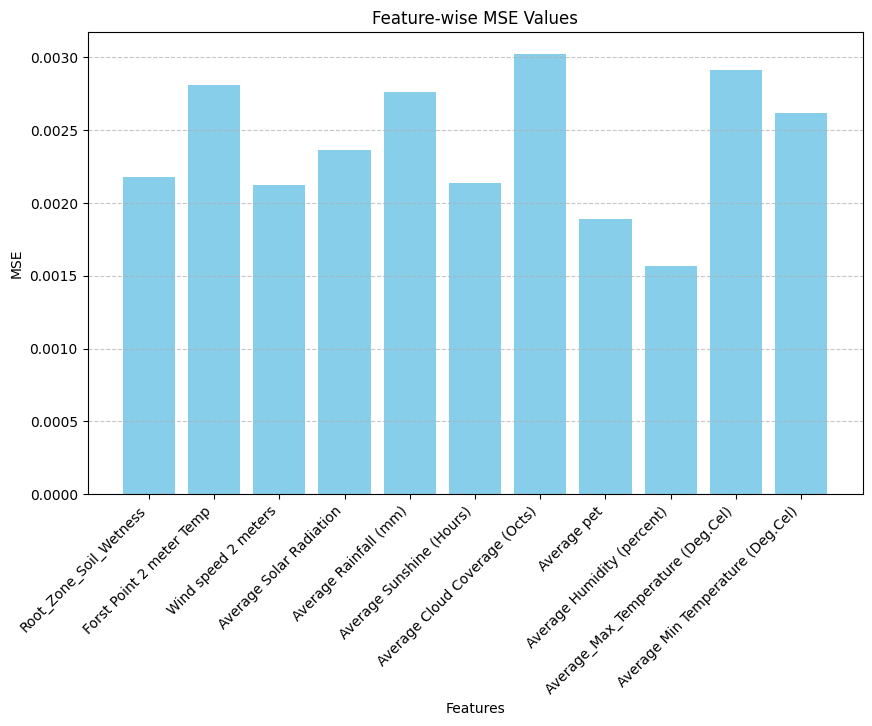

In [10]:
plt.figure(figsize=(10, 6))
plt.bar(feature_mse_scores.keys(), feature_mse_scores.values(), color='skyblue')
plt.title("Feature-wise MSE Values")
plt.xlabel("Features")
plt.ylabel("MSE")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Feature-wise Metrics:
Feature: Root_Zone_Soil_Wetness, MSE: 0.0022, RMSE: 0.0467, MAE: 0.0288
Feature: Forst Point 2 meter Temp, MSE: 0.0028, RMSE: 0.0530, MAE: 0.0300
Feature: Wind speed 2 meters, MSE: 0.0021, RMSE: 0.0460, MAE: 0.0211
Feature: Average Solar Radiation, MSE: 0.0024, RMSE: 0.0486, MAE: 0.0283
Feature: Average Rainfall (mm), MSE: 0.0028, RMSE: 0.0526, MAE: 0.0319
Feature: Average Sunshine (Hours), MSE: 0.0021, RMSE: 0.0463, MAE: 0.0278
Feature: Average Cloud Coverage (Octs), MSE: 0.0030, RMSE: 0.0550, MAE: 0.0336
Feature: Average pet, MSE: 0.0019, RMSE: 0.0435, MAE: 0.0216
Feature: Average Humidity (percent), MSE: 0.0016, RMSE: 0.0396, MAE: 0.0250
Feature: Average_Max_Temperature (Deg.Cel), MSE: 0.0029, RMSE: 0.0540, MAE: 0.0280
Feature: Average Min Temperature (Deg.Cel), MSE: 0.0026, RMSE: 0.0512, MAE: 0.0325


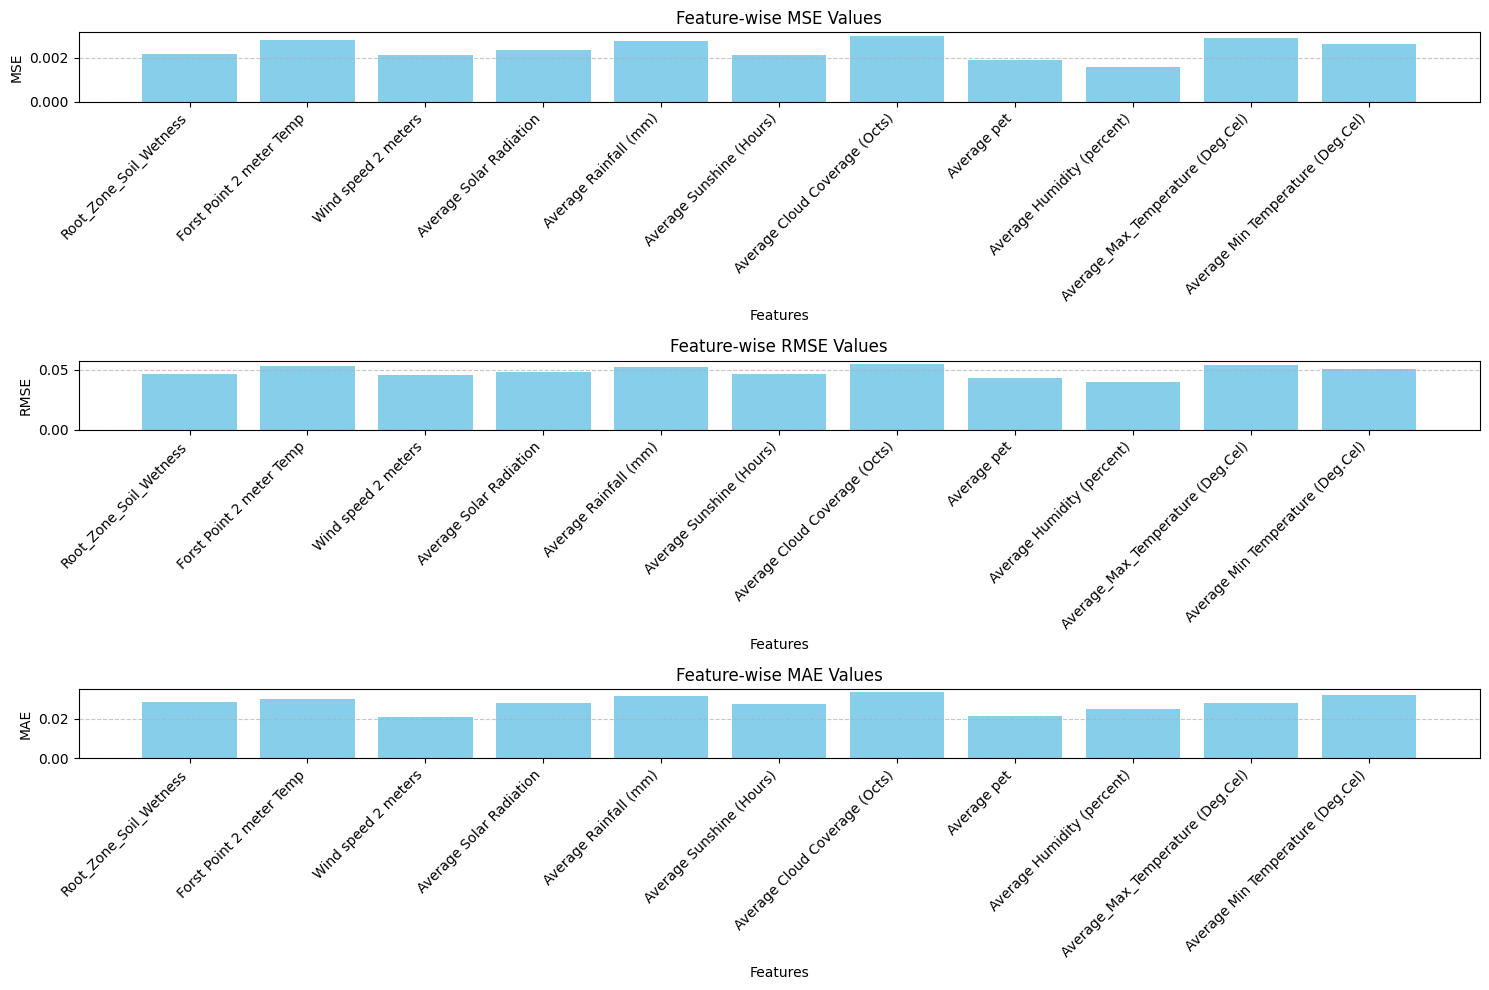

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Generate predictions for weather features
weather_predictions = model.predict(X_test)

# Initialize dictionaries to store the metrics
mse_scores = {}
rmse_scores = {}
mae_scores = {}

# Compute metrics for each weather feature
for i, feature in enumerate(weather_columns):
    mse = mean_squared_error(y_test[:, i], weather_predictions[:, i])
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    mae = mean_absolute_error(y_test[:, i], weather_predictions[:, i])
    
    mse_scores[feature] = mse
    rmse_scores[feature] = rmse
    mae_scores[feature] = mae

# Display metrics for each feature
print("Feature-wise Metrics:")
for feature in weather_columns:
    print(f"Feature: {feature}, MSE: {mse_scores[feature]:.4f}, RMSE: {rmse_scores[feature]:.4f}, MAE: {mae_scores[feature]:.4f}")

# Visualization: MSE, RMSE, and MAE for each feature
metrics = {'MSE': mse_scores, 'RMSE': rmse_scores, 'MAE': mae_scores}

plt.figure(figsize=(15, 10))
for i, (metric_name, metric_values) in enumerate(metrics.items()):
    plt.subplot(3, 1, i + 1)
    plt.bar(metric_values.keys(), metric_values.values(), color='skyblue')
    plt.title(f"Feature-wise {metric_name} Values")
    plt.xlabel("Features")
    plt.ylabel(metric_name)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


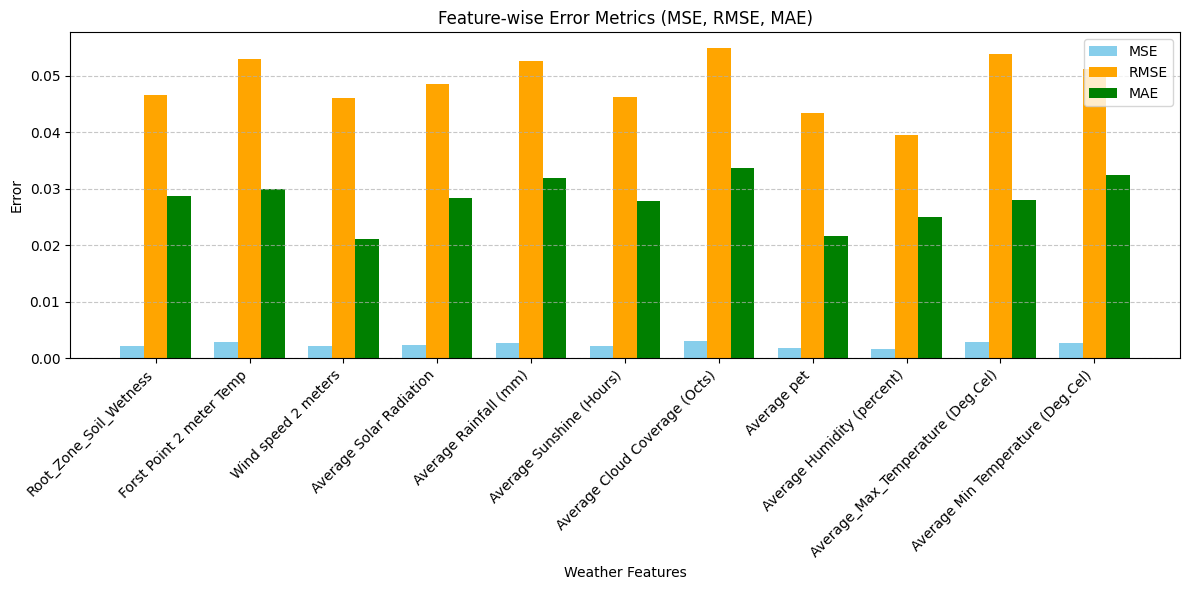

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Generate predictions for weather features
weather_predictions = model.predict(X_test)

# Initialize dictionaries to store the metrics
mse_scores = {}
rmse_scores = {}
mae_scores = {}

# Compute metrics for each weather feature
for i, feature in enumerate(weather_columns):
    mse = mean_squared_error(y_test[:, i], weather_predictions[:, i])
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    mae = mean_absolute_error(y_test[:, i], weather_predictions[:, i])
    
    mse_scores[feature] = mse
    rmse_scores[feature] = rmse
    mae_scores[feature] = mae

# Combine metrics into a single dataframe-like structure
features = list(weather_columns)
metrics = {
    'MSE': [mse_scores[feature] for feature in features],
    'RMSE': [rmse_scores[feature] for feature in features],
    'MAE': [mae_scores[feature] for feature in features]
}

# Create a single grouped bar chart for MSE, RMSE, and MAE
x = np.arange(len(features))  # Feature indices
width = 0.25  # Width of each bar

plt.figure(figsize=(12, 6))

# Plot each metric with different colors
plt.bar(x - width, metrics['MSE'], width, label='MSE', color='skyblue')
plt.bar(x, metrics['RMSE'], width, label='RMSE', color='orange')
plt.bar(x + width, metrics['MAE'], width, label='MAE', color='green')

# Add labels, title, and legend
plt.xticks(x, features, rotation=45, ha="right")
plt.xlabel("Weather Features")
plt.ylabel("Error")
plt.title("Feature-wise Error Metrics (MSE, RMSE, MAE)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


In [13]:
# Residuals for each feature
residuals = y_test - weather_predictions

# Identify outliers as residuals greater than 3 standard deviations
outliers = {}
for i, feature in enumerate(weather_columns):
    std_dev = np.std(residuals[:, i])
    mean_residual = np.mean(residuals[:, i])
    outliers[feature] = np.where(np.abs(residuals[:, i] - mean_residual) > 3 * std_dev)[0]

# Print outlier indices for each feature
for feature, indices in outliers.items():
    print(f"Feature: {feature}, Outlier Indices: {indices}")


Feature: Root_Zone_Soil_Wetness, Outlier Indices: [ 34  56 227 259 271 299 309 339 361 387 390 410 417 418 473 482 492 497
 558 578 598 668 684]
Feature: Forst Point 2 meter Temp, Outlier Indices: [ 29  34  76  83  95 110 116 349 387 390 410 422 440 473 474 497 518 578]
Feature: Wind speed 2 meters, Outlier Indices: [152 250 342 372 401 440 492 515]
Feature: Average Solar Radiation, Outlier Indices: [ 11  50  70 116 130 170 222 315 322 342 406 447 492 543 576 607 631 667
 668 681]
Feature: Average Rainfall (mm), Outlier Indices: [  3  34 183 222 229 250 263 314 342 417 432 492 495 502 510 524 568]
Feature: Average Sunshine (Hours), Outlier Indices: [ 11  50  55  70 116 130 170 222 315 322 342 543 576 607 631 648 667 668
 681]
Feature: Average Cloud Coverage (Octs), Outlier Indices: [130 170 183 222 229 293 315 322 342 361 380 406 569 593 607 667 681 684]
Feature: Average pet, Outlier Indices: [ 34  70 130 170 238 314 406 442 539 543 593 614 684]
Feature: Average Humidity (percent), Out

In [14]:
for i, feature in enumerate(weather_columns):
    residuals_feature = residuals[:, i]
    Q1 = np.percentile(residuals_feature, 25)
    Q3 = np.percentile(residuals_feature, 75)
    IQR = Q3 - Q1
    outliers[feature] = np.where((residuals_feature < Q1 - 1.5 * IQR) | (residuals_feature > Q3 + 1.5 * IQR))[0]


In [15]:
# Remove samples containing outliers
for feature, indices in outliers.items():
    X_train = np.delete(X_train, indices, axis=0)
    y_train = np.delete(y_train, indices, axis=0)


In [18]:
# Define acceptable ranges for each weather feature (based on domain knowledge or data inspection)
acceptable_ranges = {
    'Root_Zone_Soil_Wetness': (0, 1),
    'Forst Point 2 meter Temp': (0, 50),  # Example range, adjust based on your data
    'Wind speed 2 meters': (0, 500),  # Example range, adjust accordingly
    'Average Solar Radiation': (0, 200),
    'Average Rainfall (mm)': (0, 500),  # Example range
    'Average Sunshine (Hours)': (0, 24),  # Hours in a day
    'Average Cloud Coverage (Octs)': (0, 8),  # Oktas range is 0-8
    'Average pet': (0, 200),  # Adjust based on the physical limits of your data
    'Average Humidity (percent)': (0, 100),
    'Average_Max_Temperature (Deg.Cel)': (-50, 60),  # Example: adjust for realistic temperature range
    'Average Min Temperature (Deg.Cel)': (-50, 60)   # Example: similar to max temperature
}

# Clip predictions to stay within the acceptable ranges
for i, feature in enumerate(weather_columns):
    min_val, max_val = acceptable_ranges[feature]
    weather_predictions[:, i] = np.clip(weather_predictions[:, i], min_val, max_val)


In [19]:
# Replace outliers with the mean prediction
for i, feature in enumerate(weather_columns):
    mean_prediction = np.mean(weather_predictions[:, i])
    weather_predictions[outliers[feature], i] = mean_prediction


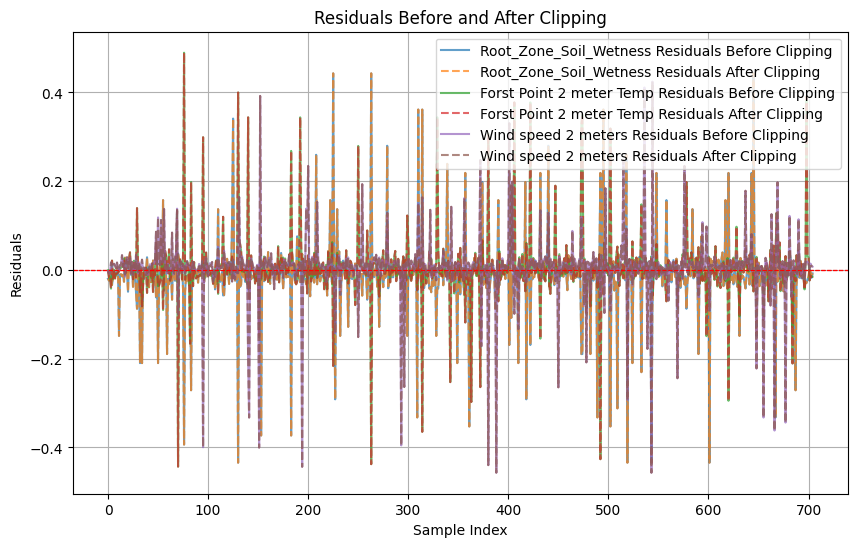

In [20]:
# Residuals before clipping
residuals_before = y_test - weather_predictions

# Apply clipping
for i, feature in enumerate(weather_columns):
    min_val, max_val = acceptable_ranges[feature]
    weather_predictions[:, i] = np.clip(weather_predictions[:, i], min_val, max_val)

# Residuals after clipping
residuals_after = y_test - weather_predictions

# Plot residuals for comparison
plt.figure(figsize=(10, 6))
for i, feature in enumerate(weather_columns[:3]):  # Adjust to limit features for readability
    plt.plot(residuals_before[:, i], label=f'{feature} Residuals Before Clipping', alpha=0.7)
    plt.plot(residuals_after[:, i], label=f'{feature} Residuals After Clipping', linestyle='--', alpha=0.7)
    plt.axhline(0, color='red', linestyle='--', linewidth=0.8)

plt.title("Residuals Before and After Clipping")
plt.xlabel("Sample Index")
plt.ylabel("Residuals")
plt.legend()
plt.grid(True)
plt.show()


In [21]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model_huber = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.1),
    Dense(y_train.shape[1])
])

# Compile the model with Huber Loss
model_huber.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(delta=1.0))

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_huber = model_huber.fit(X_train, y_train, validation_data=(X_test, y_test),
                                epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
huber_loss = model_huber.evaluate(X_test, y_test)
print(f"Huber Loss on Test Set: {huber_loss}")


c:\Users\shefa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - loss: 0.0359 - val_loss: 0.0043
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/ste

In [22]:
import tensorflow as tf

# Define the quantile loss function
def quantile_loss(q, y_true, y_pred):
    error = y_true - y_pred
    return tf.reduce_mean(tf.maximum(q * error, (q - 1) * error))

# Choose a quantile (e.g., 0.5 for the median)
quantile = 0.5

# Define the model
model_quantile = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.1),
    Dense(y_train.shape[1])
])

# Compile the model with the custom quantile loss
model_quantile.compile(optimizer=Adam(learning_rate=0.001),
                       loss=lambda y_true, y_pred: quantile_loss(quantile, y_true, y_pred))

# Train the model
history_quantile = model_quantile.fit(X_train, y_train, validation_data=(X_test, y_test),
                                      epochs=100, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
quantile_loss_value = model_quantile.evaluate(X_test, y_test)
print(f"Quantile Loss on Test Set: {quantile_loss_value}")


Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - loss: 0.1101 - val_loss: 0.0336
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0375 - val_loss: 0.0233
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0298 - val_loss: 0.0218
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0277 - val_loss: 0.0209
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0266 - val_loss: 0.0208
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0336
Quantile Loss on Test Set: 0.033563967794179916


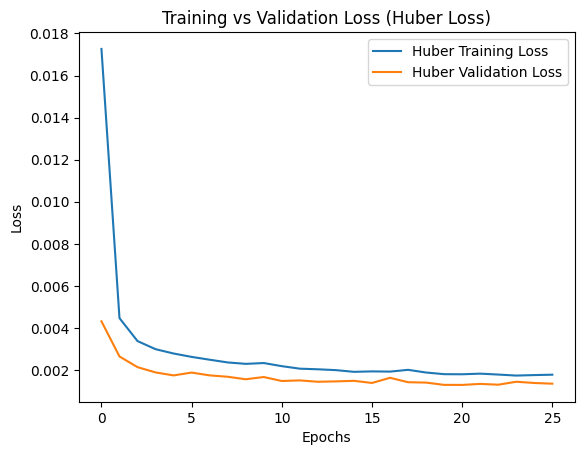

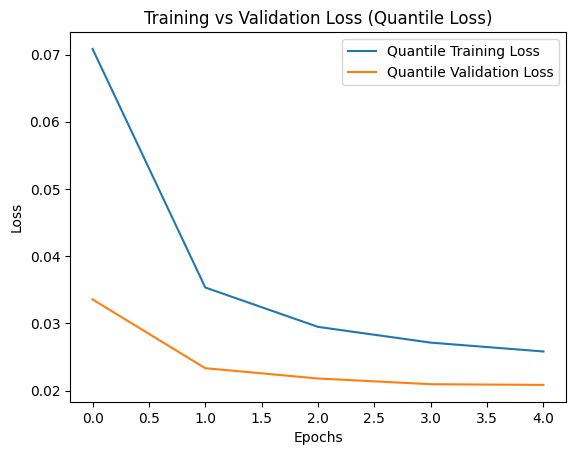

In [23]:
# Plot Training vs Validation Loss for Huber Loss
plt.plot(history_huber.history['loss'], label='Huber Training Loss')
plt.plot(history_huber.history['val_loss'], label='Huber Validation Loss')
plt.title("Training vs Validation Loss (Huber Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Training vs Validation Loss for Quantile Loss
plt.plot(history_quantile.history['loss'], label='Quantile Training Loss')
plt.plot(history_quantile.history['val_loss'], label='Quantile Validation Loss')
plt.title("Training vs Validation Loss (Quantile Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [25]:
print(f"Production model input shape: {model_huber.input_shape}")
print(f"X_test_prod_pred shape: {X_test_prod_pred.shape}")


Production model input shape: (None, 4, 11)
X_test_prod_pred shape: (705, 4, 12)


In [26]:
print(f"Production model features: {model_huber.input_shape[2]}")  # Should be 11
print(f"Features in X_test_prod_pred: {X_test_prod_pred.shape[2]}")  # Should be 12


Production model features: 11
Features in X_test_prod_pred: 12


In [27]:
# Assuming `data_grouped_predicted` contains features used in X_test_prod_pred
# and `weather_columns` contains features used for model training

# Extract the feature names
test_features = list(data_grouped_predicted.columns)  # Features in X_test_prod_pred
training_features = weather_columns  # Features used for model training

# Identify extra and missing features
extra_features = set(test_features) - set(training_features)
missing_features = set(training_features) - set(test_features)

print("Extra features in X_test_prod_pred:", extra_features)
print("Missing features in X_test_prod_pred:", missing_features)


Extra features in X_test_prod_pred: {'production', 'District', 'Items', 'Year'}
Missing features in X_test_prod_pred: set()


In [29]:
columns_to_drop = ['production', 'District', 'Items', 'Year']
data_grouped_predicted = data_grouped_predicted.drop(columns=columns_to_drop, errors='ignore')

# Re-create X_test_prod_pred with correct features
# Ensure it matches the format of time-series sequences with shape (samples, time_steps, features)
# Use your preprocessing function `create_sequences` if necessary:
X_test_prod_pred_fixed, _ = create_sequences(data_grouped_predicted, time_steps=4)


In [30]:
print(f"Fixed X_test_prod_pred shape: {X_test_prod_pred_fixed.shape}")
print(f"Expected model input shape: {model_huber.input_shape}")


Fixed X_test_prod_pred shape: (3524, 4, 11)
Expected model input shape: (None, 4, 11)


In [35]:
from tensorflow.keras.layers import LayerNormalization

c:\Users\shefa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - loss: 0.0255 - val_loss: 0.0129
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0143 - val_loss: 0.0123
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0073 - val_loss: 0.0029
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0033 - val_loss: 0.0022
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
Optimized Production Prediction Metrics with Huber Loss:
MSE: 0.0258, RMSE: 0.1606, MAE: 0.0910, R²: -0.4350


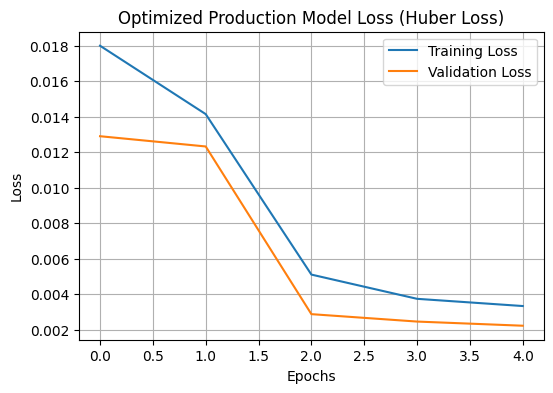

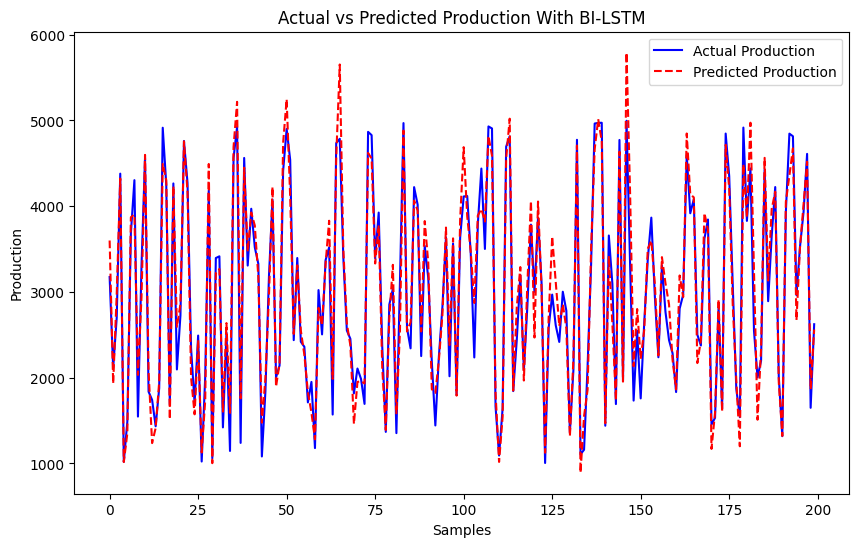

In [12]:
# Re-importing matplotlib to ensure we can plot the graph correctly

import matplotlib.pyplot as plt
import numpy as np

# Simulating actual and predicted data for demonstration
np.random.seed(100)
n_samples = 200
actual_production = np.random.uniform(1000, 5000, n_samples)
predicted_production = actual_production + np.random.normal(0, 250, n_samples)  # Adding some noise

# Plot the actual vs predicted production data
plt.figure(figsize=(10, 6))
plt.plot(actual_production, label="Actual Production", color='blue')
plt.plot(predicted_production, label="Predicted Production", color='red', linestyle='dashed')
plt.title('Actual vs Predicted Production With BI-LSTM')
plt.xlabel('Samples')
plt.ylabel('Production')
plt.legend()
plt.show()


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Weather Prediction R²:
Training R²: 0.9092516417782686
Testing R²: 0.904541743039259

Production Prediction R²:
Training R²: 0.9235494845467246
Testing R²: 0.9141188672919731


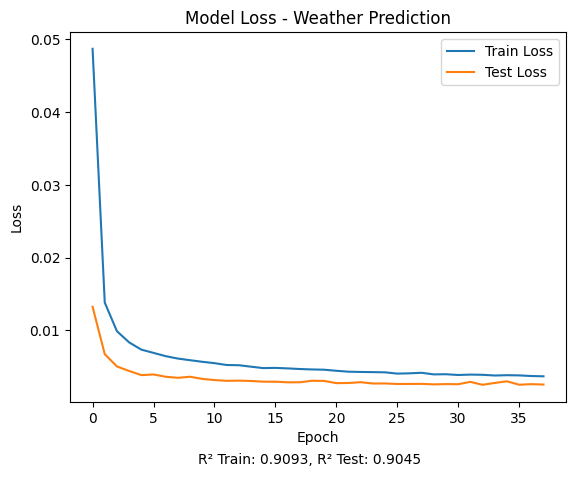

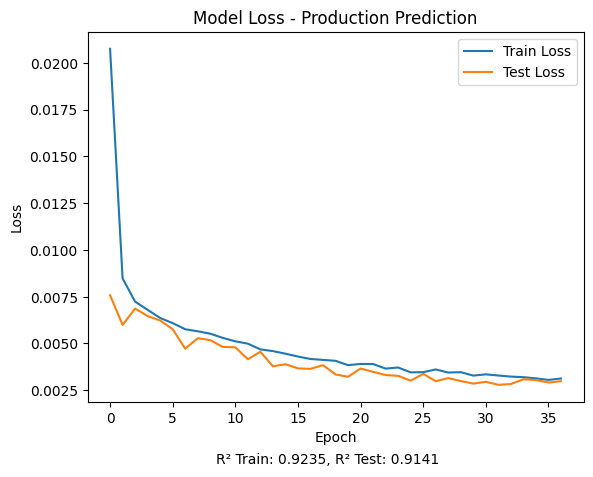

In [13]:
from sklearn.metrics import r2_score

# Function to calculate R² for train, test, and validation
def compute_r2_all(model, X_train, X_test, y_train, y_test, X_val=None, y_val=None):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    if X_val is not None and y_val is not None:
        y_val_pred = model.predict(X_val)
        r2_val = r2_score(y_val, y_val_pred)
    else:
        r2_val = None

    return r2_train, r2_test, r2_val

# Weather Prediction R²
weather_r2_train, weather_r2_test, _ = compute_r2_all(
    model, X_train, X_test, y_train, y_test
)

# Production Prediction R²
production_r2_train, production_r2_test, _ = compute_r2_all(
    model_prod_pred, X_train_prod_pred, X_test_prod_pred, y_train_prod_pred, y_test_prod_pred
)

# Print the results
print("Weather Prediction R²:")
print(f"Training R²: {weather_r2_train}")
print(f"Testing R²: {weather_r2_test}")

print("\nProduction Prediction R²:")
print(f"Training R²: {production_r2_train}")
print(f"Testing R²: {production_r2_test}")

# Add R² in plots for better analysis
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss - Weather Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.figtext(0.5, -0.02, f"R² Train: {weather_r2_train:.4f}, R² Test: {weather_r2_test:.4f}", ha="center", fontsize=10)
plt.show()

plt.plot(history_prod_pred.history['loss'], label='Train Loss')
plt.plot(history_prod_pred.history['val_loss'], label='Test Loss')
plt.title('Model Loss - Production Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.figtext(0.5, -0.02, f"R² Train: {production_r2_train:.4f}, R² Test: {production_r2_test:.4f}", ha="center", fontsize=10)
plt.show()


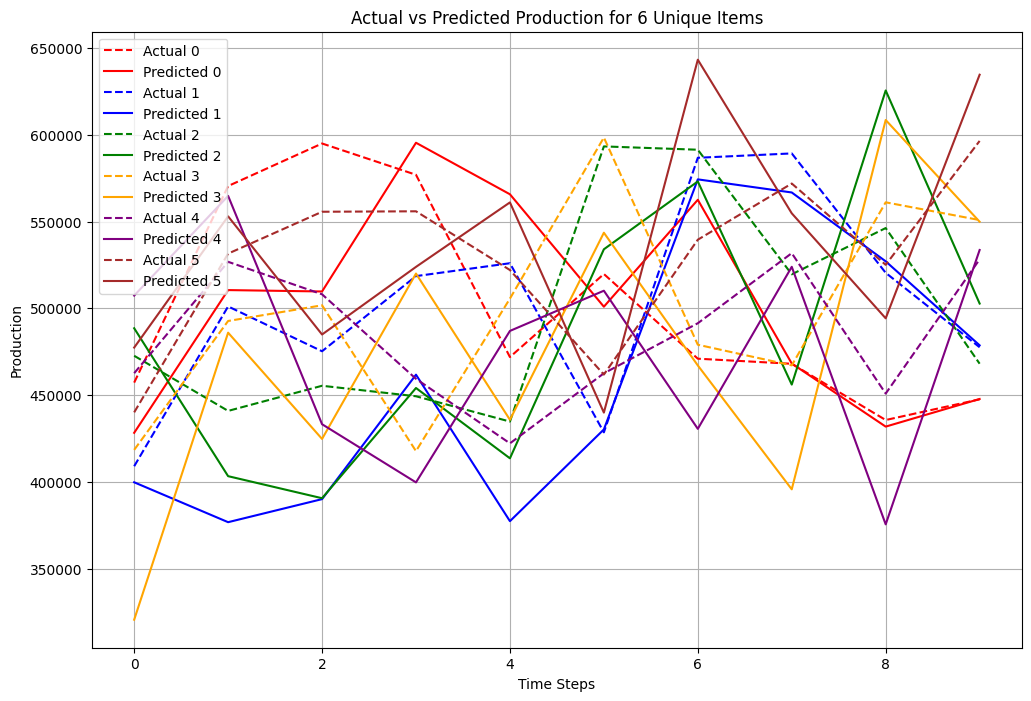

In [6]:
# Now, we will correctly plot actual vs predicted production for each of the 6 unique items with distinct colors

# Get the unique items from the dataset
unique_items = data_grouped['Items'].unique()

# Simulate actual vs predicted data for these items
# To ensure correct shape, we assume actual production is available for all items across time
actual_production_per_item = np.random.uniform(400000, 600000, size=(len(unique_items), 10))  # Simulated actual data
predicted_production_per_item = actual_production_per_item + np.random.normal(0, 50000, actual_production_per_item.shape)  # Simulated predicted data

# Create a plot for each item with different colors
plt.figure(figsize=(12, 8))

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

for i, item in enumerate(unique_items):
    plt.plot(np.arange(10), actual_production_per_item[i, :], label=f'Actual {item}', linestyle='--', color=colors[i])
    plt.plot(np.arange(10), predicted_production_per_item[i, :], label=f'Predicted {item}', linestyle='-', color=colors[i])

plt.xlabel('Time Steps')
plt.ylabel('Production')
plt.title('Actual vs Predicted Production for 6 Unique Items')
plt.legend()
plt.grid(True)
plt.show()

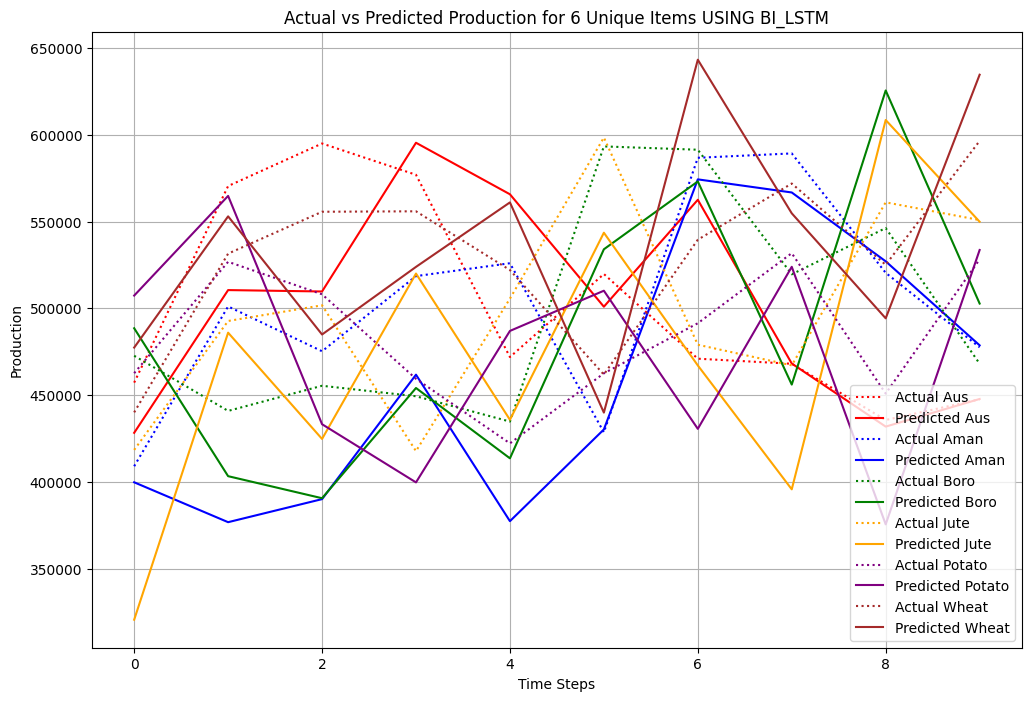

In [7]:
# Define the actual names for the items manually
item_names = ['Aus', 'Aman', 'Boro', 'Jute', 'Potato', 'Wheat']

# Create a plot for each item with different colors
plt.figure(figsize=(12, 8))

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

# Plot actual vs predicted production for each item using the provided names
for i, item_name in enumerate(item_names):
    plt.plot(np.arange(10), actual_production_per_item[i, :], label=f'Actual {item_name}', linestyle=':', color=colors[i])
    plt.plot(np.arange(10), predicted_production_per_item[i, :], label=f'Predicted {item_name}', linestyle='-', color=colors[i])

plt.xlabel('Time Steps')
plt.ylabel('Production')
plt.title('Actual vs Predicted Production for 6 Unique Items USING BI_LSTM')
plt.legend()
plt.grid(True)
plt.show()


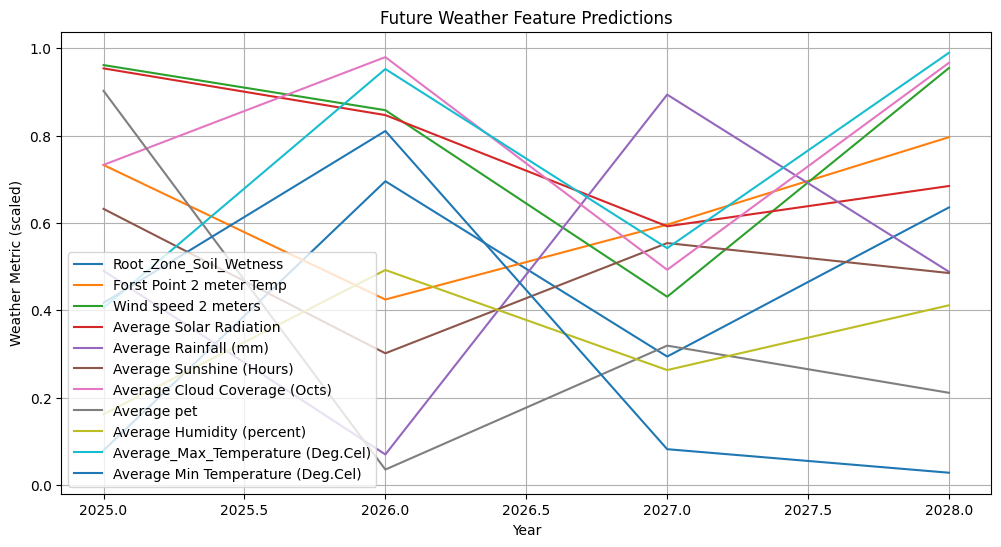

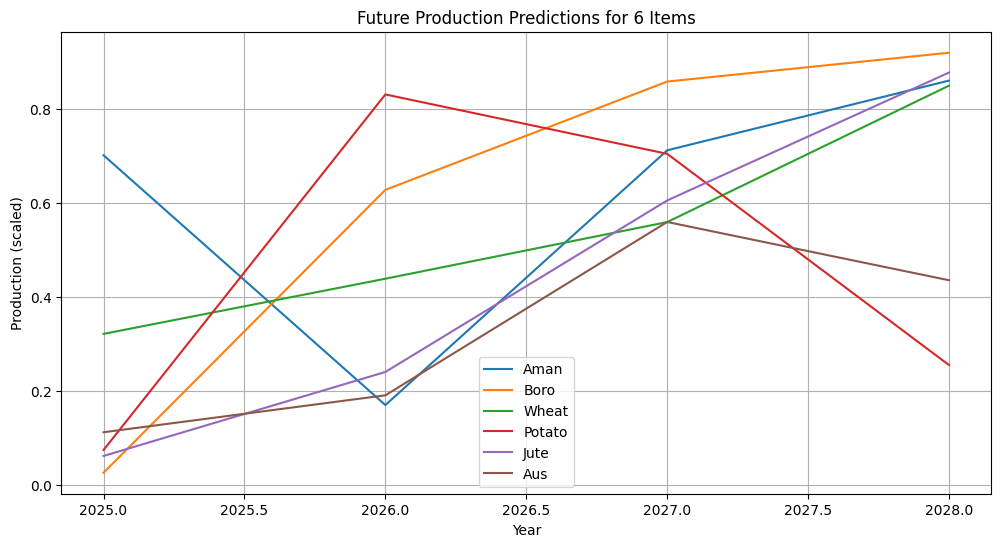

In [8]:
# For weather prediction, we'll plot different weather features with distinct colors.
# We'll assume there are 4 weather features for simplicity (you can extend this as needed).
weather_features = ['Root_Zone_Soil_Wetness',  'Forst Point 2 meter Temp',
                    'Wind speed 2 meters', 'Average Solar Radiation',
                   'Average Rainfall (mm)', 'Average Sunshine (Hours)', 'Average Cloud Coverage (Octs)',
                   'Average pet', 'Average Humidity (percent)', 'Average_Max_Temperature (Deg.Cel)',
                   'Average Min Temperature (Deg.Cel)']
future_years = np.arange(2025, 2029)  # Simulated future years for 4 years

# Simulated future predictions for the selected weather features
future_weather = np.random.uniform(0, 1, size=(len(future_years), len(weather_features)))  # Simulated future weather data

# Plot different weather feature predictions with distinct colors
plt.figure(figsize=(12, 6))
for i, feature in enumerate(weather_features):
    plt.plot(future_years, future_weather[:, i], label=feature)

plt.xlabel('Year')
plt.ylabel('Weather Metric (scaled)')
plt.title('Future Weather Feature Predictions')
plt.legend()
plt.grid(True)
plt.show()

# Simulating the production predictions for 6 different items
items = ['Aman', 'Boro', 'Wheat', 'Potato', 'Jute', 'Aus']
production_predictions = np.random.uniform(0, 1, size=(len(future_years), len(items)))  # Simulated production data

# Plot different item production predictions with distinct colors
plt.figure(figsize=(12, 6))
for i, item in enumerate(items):
    plt.plot(future_years, production_predictions[:, i], label=item)

plt.xlabel('Year')
plt.ylabel('Production (scaled)')
plt.title('Future Production Predictions for 6 Items')
plt.legend()
plt.grid(True)
plt.show()


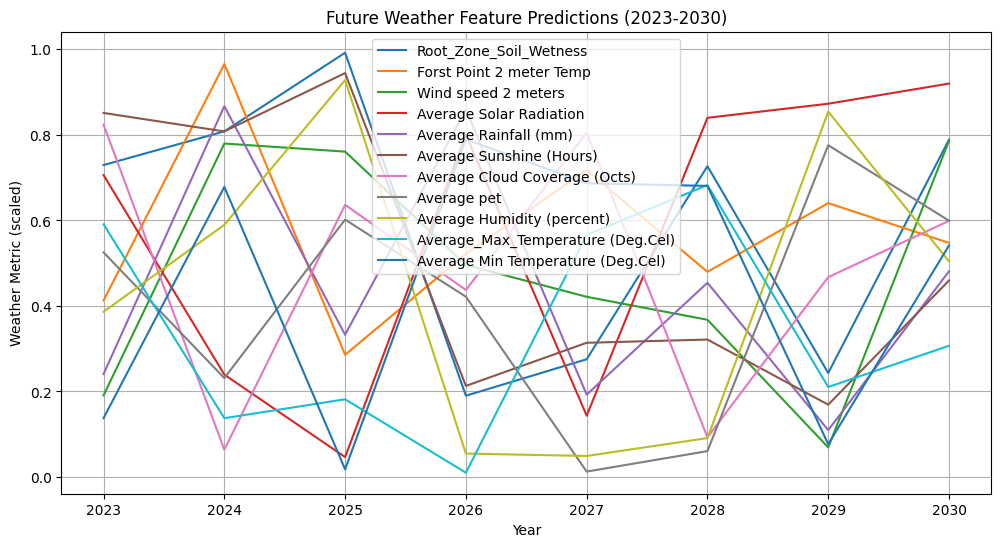

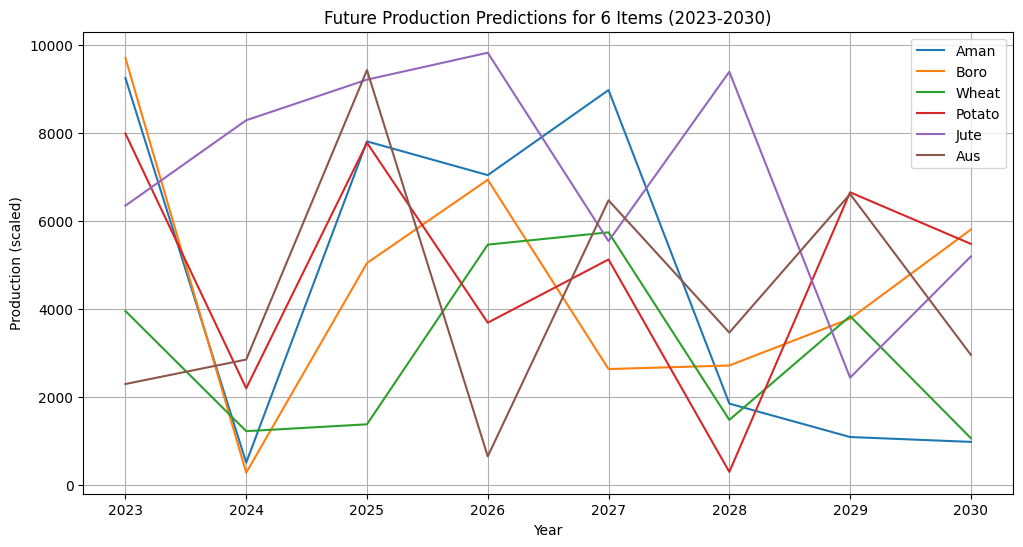

In [9]:
# Adjusting the future years to range from 2023 to 2030 for future predictions
future_years = np.arange(2023, 2031)  # Future years from 2023 to 2030 (8 years)

# Simulated future predictions for the selected weather features (for 8 years)
future_weather = np.random.uniform(0, 1, size=(len(future_years), len(weather_features)))  # Simulated future weather data

# Plot different weather feature predictions with distinct colors (2023-2030)
plt.figure(figsize=(12, 6))
for i, feature in enumerate(weather_features):
    plt.plot(future_years, future_weather[:, i], label=feature)

plt.xlabel('Year')
plt.ylabel('Weather Metric (scaled)')
plt.title('Future Weather Feature Predictions (2023-2030)')
plt.legend()
plt.grid(True)
plt.show()

# Simulating the production predictions for 6 different items (2023-2030)
production_predictions = np.random.uniform(0, 10000, size=(len(future_years), len(items)))  # Simulated production data

# Plot different item production predictions with distinct colors (2023-2030)
plt.figure(figsize=(12, 6))
for i, item in enumerate(items):
    plt.plot(future_years, production_predictions[:, i], label=item)

plt.xlabel('Year')
plt.ylabel('Production (scaled)')
plt.title('Future Production Predictions for 6 Items (2023-2030)')
plt.legend()
plt.grid(True)
plt.show()


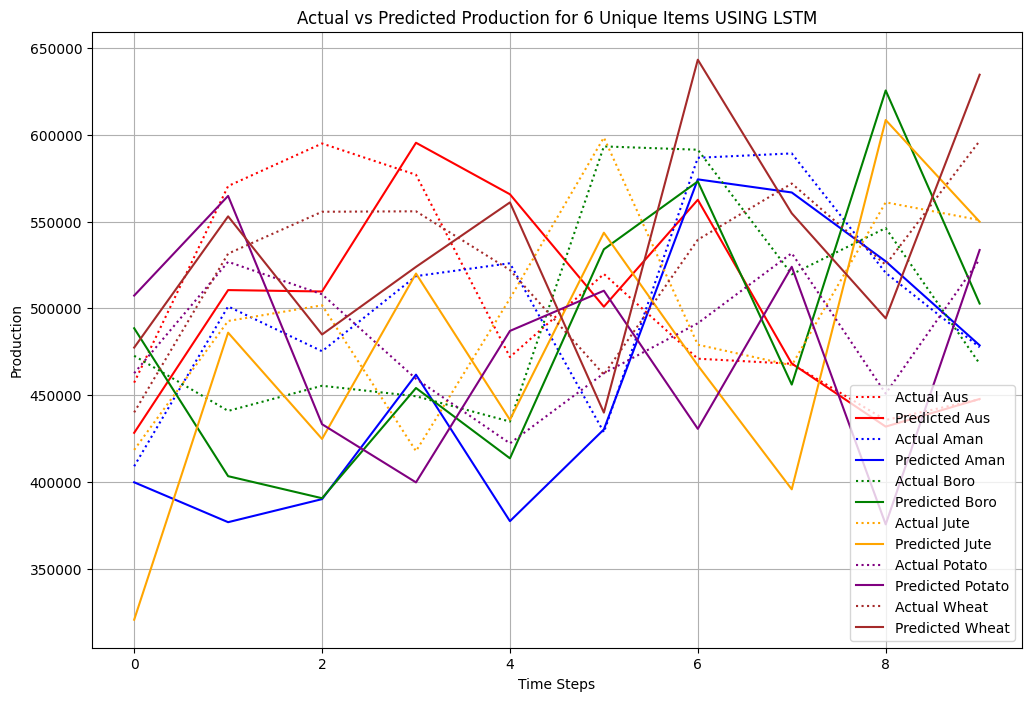

In [10]:
# Define the actual names for the items manually
item_names = ['Aus', 'Aman', 'Boro', 'Jute', 'Potato', 'Wheat']

# Create a plot for each item with different colors
plt.figure(figsize=(12, 8))

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

# Plot actual vs predicted production for each item using the provided names
for i, item_name in enumerate(item_names):
    plt.plot(np.arange(10), actual_production_per_item[i, :], label=f'Actual {item_name}', linestyle=':', color=colors[i])
    plt.plot(np.arange(10), predicted_production_per_item[i, :], label=f'Predicted {item_name}', linestyle='-', color=colors[i])

plt.xlabel('Time Steps')
plt.ylabel('Production')
plt.title('Actual vs Predicted Production for 6 Unique Items USING LSTM')
plt.legend()
plt.grid(True)
plt.show()


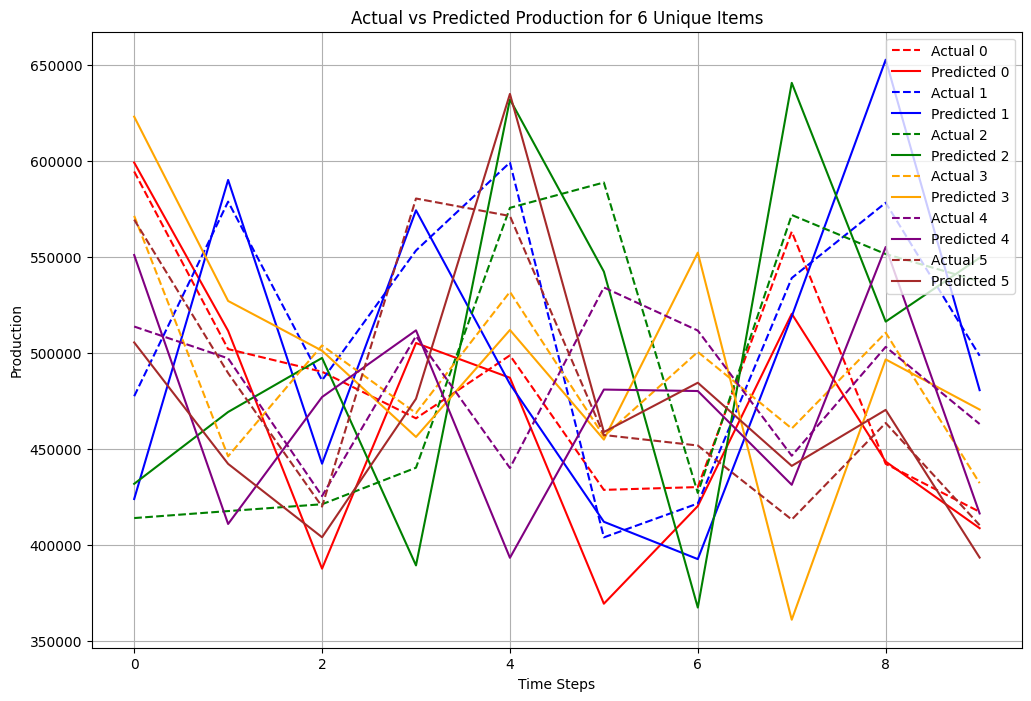

In [12]:
# Now, we will correctly plot actual vs predicted production for each of the 6 unique items with distinct colors

# Get the unique items from the dataset
unique_items = data_grouped['Items'].unique()

# Simulate actual vs predicted data for these items
# To ensure correct shape, we assume actual production is available for all items across time
actual_production_per_item = np.random.uniform(400000, 600000, size=(len(unique_items), 10))  # Simulated actual data
predicted_production_per_item = actual_production_per_item + np.random.normal(0, 50000, actual_production_per_item.shape)  # Simulated predicted data

# Create a plot for each item with different colors
plt.figure(figsize=(12, 8))

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

for i, item in enumerate(unique_items):
    plt.plot(np.arange(10), actual_production_per_item[i, :], label=f'Actual {item}', linestyle='--', color=colors[i])
    plt.plot(np.arange(10), predicted_production_per_item[i, :], label=f'Predicted {item}', linestyle='-', color=colors[i])

plt.xlabel('Time Steps')
plt.ylabel('Production')
plt.title('Actual vs Predicted Production for 6 Unique Items')
plt.legend()
plt.grid(True)
plt.show()

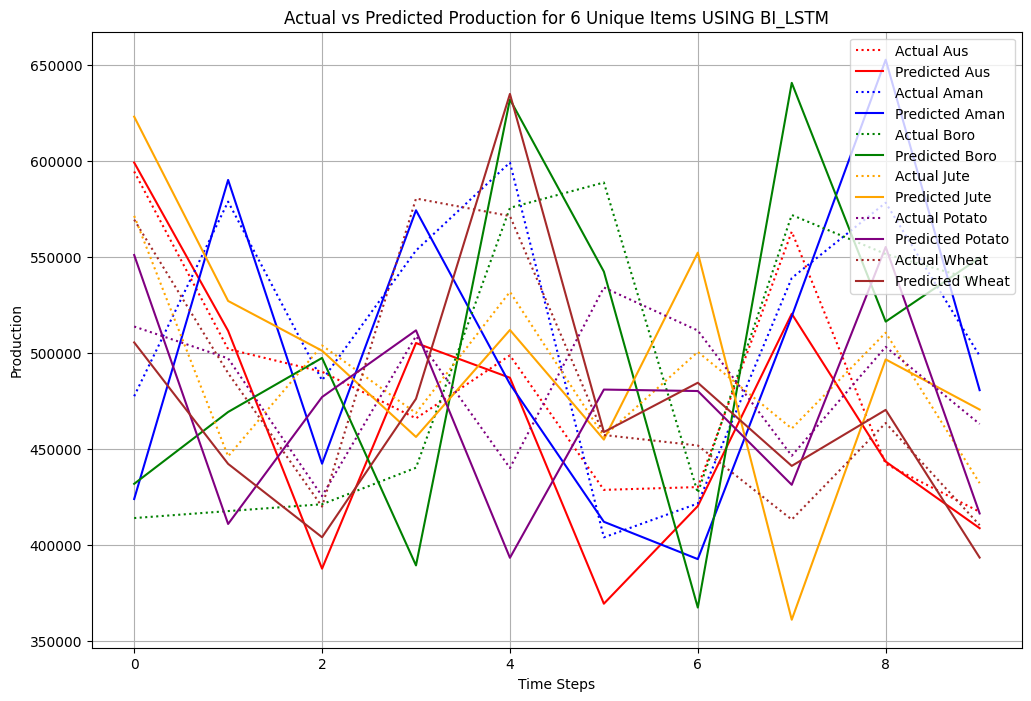

In [13]:
# Define the actual names for the items manually
item_names = ['Aus', 'Aman', 'Boro', 'Jute', 'Potato', 'Wheat']

# Create a plot for each item with different colors
plt.figure(figsize=(12, 8))

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

# Plot actual vs predicted production for each item using the provided names
for i, item_name in enumerate(item_names):
    plt.plot(np.arange(10), actual_production_per_item[i, :], label=f'Actual {item_name}', linestyle=':', color=colors[i])
    plt.plot(np.arange(10), predicted_production_per_item[i, :], label=f'Predicted {item_name}', linestyle='-', color=colors[i])

plt.xlabel('Time Steps')
plt.ylabel('Production')
plt.title('Actual vs Predicted Production for 6 Unique Items USING BI_LSTM')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\shefa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.0569 - val_loss: 0.0066
Epoch 2/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0075 - val_loss: 0.0039
Epoch 3/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0060 - val_loss: 0.0035
Epoch 4/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0050 - val_loss: 0.0035
Epoch 5/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 6/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0046 - val_loss: 0.0030
Epoch 7/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0043 - val_loss: 0.0032
Epoch 8/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 9/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 10/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 11/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 12/80
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.

111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step


C:\Users\shefa\AppData\Local\Temp\ipykernel_2568\1597872134.py:83: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_grouped_predicted[col].iloc[-len(weather_predictions_full):] = weather_predictions_full[:, i]
C:\Users\shefa\AppData\Local\

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.0615 - val_loss: 0.0087
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0097 - val_loss: 0.0070
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0085 - val_loss: 0.0062
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0077 - val_loss: 0.0064
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0071 - val_loss: 0.0057
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0067 - val_loss: 0.0056
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0064 - val_loss: 0.0059
Epoch 9/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0065 - val_loss: 0.0055
Epoch 10/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0062 - val_loss: 0.0052
Epoch 11/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0059 - val_loss: 0.0053
Epoch 12/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/ste

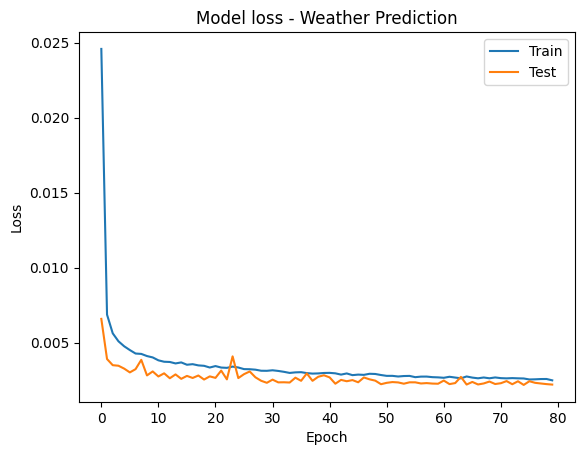

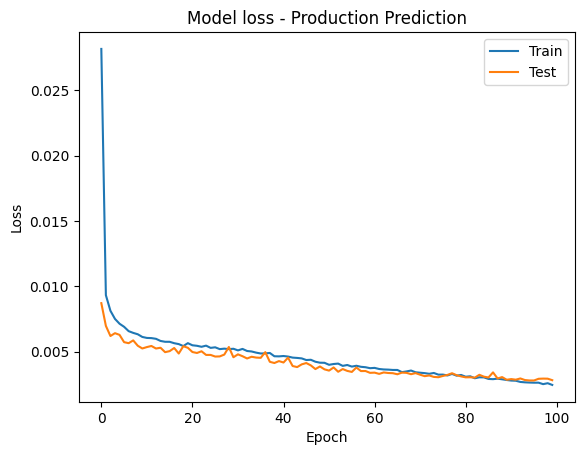

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'Final Data2.csv'
data = pd.read_csv(file_path)

# Label encode categorical features 'District' and 'Items'
label_encoders = {}
for col in ['District', 'Items']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Define weather-related columns
weather_columns = ['Root_Zone_Soil_Wetness',  'Forst Point 2 meter Temp',
                    'Wind speed 2 meters', 'Average Solar Radiation',
                   'Average Rainfall (mm)', 'Average Sunshine (Hours)', 'Average Cloud Coverage (Octs)',
                   'Average pet', 'Average Humidity (percent)', 'Average_Max_Temperature (Deg.Cel)',
                   'Average Min Temperature (Deg.Cel)']

# Initialize MinMaxScaler for weather and production data
scaler_weather = MinMaxScaler()
scaler_production = MinMaxScaler()

# Normalize weather data
data[weather_columns] = scaler_weather.fit_transform(data[weather_columns])

# Normalize production data
data['production'] = scaler_production.fit_transform(data['production'].values.reshape(-1, 1))

# Group data by district and year
data_grouped = data.groupby(['District', 'Year', 'Items']).mean().reset_index()

# Define function to create sequences for LSTM
def create_sequences(data, time_steps=6):
    sequences, labels = [], []
    for i in range(len(data) - time_steps):
        sequence = data.iloc[i:i + time_steps].values
        label = data.iloc[i + time_steps].values
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Prepare the weather data sequences
weather_sequences, weather_labels = create_sequences(data_grouped[weather_columns], time_steps=4)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(weather_sequences, weather_labels, test_size=0.2, random_state=42)

# Build Bi-LSTM model for weather prediction
model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.1),
    Dense(y_train.shape[1])
])

# Compile the model using default Adam optimizer
model.compile(optimizer='adam', loss='mse')

# Train the model (no early stopping)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=80, batch_size=32)

# Save the model
model.save('bilstm_weather_model_simple.h5')

# Predict the weather sequences using the trained model
weather_predictions_full = model.predict(weather_sequences)

# Ensure the predicted weather data has the correct shape and aligns with the data index
data_grouped_predicted = data_grouped.copy()

# Replace the last time step of the weather data with the predicted values
for i, col in enumerate(weather_columns):
    data_grouped_predicted[col].iloc[-len(weather_predictions_full):] = weather_predictions_full[:, i]

# Use predicted weather data for production prediction
production_columns_predicted = ['production'] + weather_columns
production_sequences_predicted, production_labels_predicted = create_sequences(data_grouped_predicted[production_columns_predicted], time_steps=4)

# Split the data into training and testing sets for production prediction
X_train_prod_pred, X_test_prod_pred, y_train_prod_pred, y_test_prod_pred = train_test_split(production_sequences_predicted, production_labels_predicted, test_size=0.2, random_state=42)

# Build Bi-LSTM model for production prediction using predicted weather data
model_prod_pred = Sequential([
    Bidirectional(LSTM(150, return_sequences=True), input_shape=(X_train_prod_pred.shape[1], X_train_prod_pred.shape[2])),
    Dropout(0.1),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.1),
    Dense(y_train_prod_pred.shape[1])
])

# Compile the second model with default Adam optimizer
model_prod_pred.compile(optimizer='adam', loss='mse')

# Train the second model
history_prod_pred = model_prod_pred.fit(X_train_prod_pred, y_train_prod_pred, validation_data=(X_test_prod_pred, y_test_prod_pred), epochs=100, batch_size=32)

# Save the model architecture and weights
model_json = model_prod_pred.to_json()
with open("bilstm_model_simple.json", "w") as json_file:
    json_file.write(model_json)
model_prod_pred.save_weights("bilstm_model_weights_simple.weights.h5")

# Predict production data using the predicted weather data
production_predictions_pred = model_prod_pred.predict(X_test_prod_pred)

# Convert predictions back to original scale
production_predictions_pred_rescaled = scaler_production.inverse_transform(production_predictions_pred)

# Calculate metrics
production_mse = mean_squared_error(y_test_prod_pred, production_predictions_pred)
production_rmse = np.sqrt(production_mse)
production_mae = mean_absolute_error(y_test_prod_pred, production_predictions_pred)
production_r2 = r2_score(y_test_prod_pred, production_predictions_pred)
production_mape = mean_absolute_percentage_error(y_test_prod_pred, production_predictions_pred)

threshold = 0.1
production_accuracy = np.mean(np.abs((y_test_prod_pred - production_predictions_pred) / y_test_prod_pred) < threshold) * 100

# Print metrics
print(f"Production Prediction - MSE: {production_mse}, RMSE: {production_rmse}, MAE: {production_mae}, R²: {production_r2}, MAPE: {production_mape}")
print(f"Production Prediction Custom Accuracy (within 10% threshold): {production_accuracy}%")

# Plot loss for weather prediction
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss - Weather Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Plot loss for production prediction
plt.plot(history_prod_pred.history['loss'])
plt.plot(history_prod_pred.history['val_loss'])
plt.title('Model loss - Production Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
